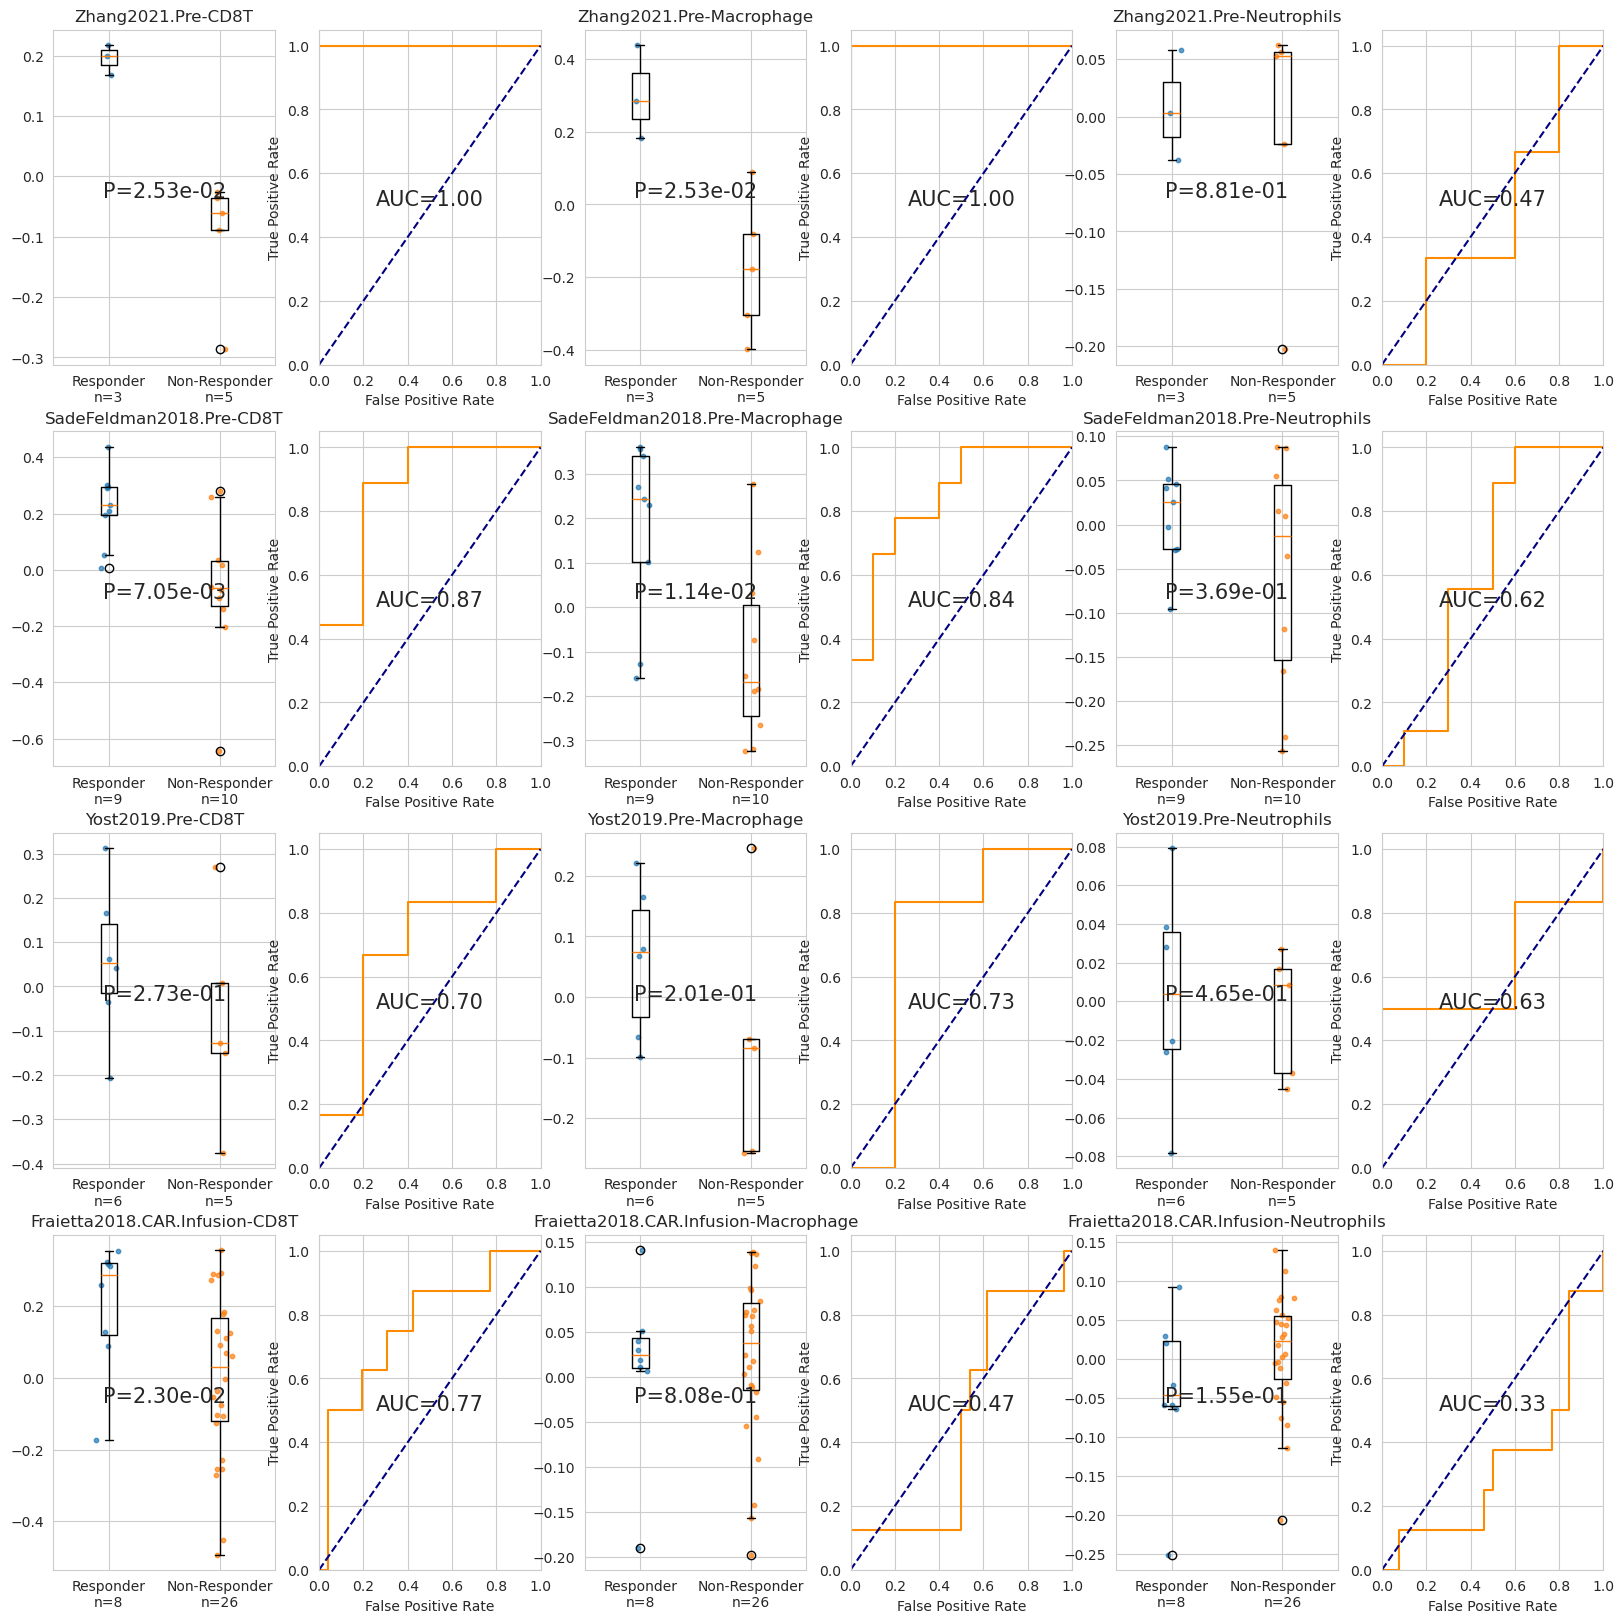

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import pandas as pd
import os
from scipy.stats import ranksums
from sklearn import metrics

celltype_list = ['CD8T', 'Macrophage', 'Neutrophils']
dataset_list = ["Zhang2021", "SadeFeldman2018", "Yost2019", "Fraietta2018"]
state_list = ['Pre', "Pre", "Pre", "CAR.Infusion"]

fig = plt.figure(figsize=(20, 5 * len(dataset_list)))
gs = gridspec.GridSpec(nrows=len(dataset_list), ncols=6, width_ratios=[1, 1, 1, 1, 1, 1])
for celltype in celltype_list:
    for i in range(len(dataset_list)):
        dataset = dataset_list[i]
        state = state_list[i]
    
        correlation_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/3.CD8T_analysis/{dataset}.correlation.{celltype}.csv'
        sample_annotation_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/3.CD8T_analysis/{dataset}/{dataset}.sample_annotation.txt'
    
        if dataset == 'Zhang2021':
            bulk_profile_path = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/test/data/Atezolizumab+Paclitaxel_Pre_Zhang2021_TNBC.csv'
        elif dataset == 'SadeFeldman2018':
            bulk_profile_path = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/test/data/ICB_Pre_SadeFeldman2018_Melanoma.csv'
        elif dataset == 'Yost2019':
            bulk_profile_path = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/test/data/anti-PD1_Pre_Yost2019_BCC.csv'
        elif dataset == 'Fraietta2018':
            bulk_profile_path = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/test/data/CD19CAR_Infusion.CAR_Fraietta2018_CLL.csv'
        bulk_profile_df = pd.read_csv(bulk_profile_path, index_col=0)
    
        correlation_df = pd.read_csv(correlation_path, header=0, index_col=0)
        sample_annotation_df = pd.read_csv(sample_annotation_path, delimiter='\t', header=0, index_col=0)
    
        # filter the Pre sample
        sample_list = sample_annotation_df.index.values.tolist()
        if dataset == 'Yost2019':
            pre_tcell = [col for col in sample_list if 'pre.tcell' in col]
            pre_tcell_patient = [col.split('.')[1] for col in pre_tcell]
            others = [x for x in sample_list if x not in pre_tcell]
            for sample in others:
                if sample.split('.')[1] in pre_tcell_patient:
                    continue
                else:
                    if 'pre' in sample:
                        pre_tcell.append(sample)
            sample_list = pre_tcell
    
        if dataset != 'Fraietta2018':
            sample_list = [sample for sample in sample_list if state.lower() in sample.lower()]
            sample_annotation_df = sample_annotation_df.loc[sample_list]
    
        # response_correlation = correlation_df.loc[sample_annotation_df[sample_annotation_df['response'] == 'R'].index]
        # nonresponse_correlation = correlation_df.loc[sample_annotation_df[sample_annotation_df['response'] == 'NR'].index]
    
        response_correlation = correlation_df.loc[[col for col in bulk_profile_df.columns if 'True' in col]]
        nonresponse_correlation = correlation_df.loc[[col for col in bulk_profile_df.columns if 'False' in col]]
    
        correlation_data = [np.array(response_correlation).ravel(), np.array(nonresponse_correlation).ravel()]
        p_value = ranksums(response_correlation, nonresponse_correlation).pvalue
        p_value_format = format(p_value[0], '0.2e')
    
        if celltype == 'CD8T':
            ax1 = fig.add_subplot(gs[i, 0])
            ax2 = fig.add_subplot(gs[i, 1])
        elif celltype == 'Macrophage':
            ax1 = fig.add_subplot(gs[i, 2])
            ax2 = fig.add_subplot(gs[i, 3])
        elif celltype == 'Neutrophils':
            ax1 = fig.add_subplot(gs[i, 4])
            ax2 = fig.add_subplot(gs[i, 5])
    
        ax1.boxplot(correlation_data)
        # add scatter
        for i in range(len(correlation_data)):
            y = correlation_data[i]
            x = np.random.normal(i + 1, 0.04, size=len(y))
            ax1.scatter(x, y, alpha=0.7, s=10)
        y_mean = (max(max(row) for row in correlation_data) + min(min(row) for row in correlation_data)) / 2
        ax1.text(1.5, y_mean, f'P={p_value_format}', ha='center', fontsize=15)
        ax1.set_xticks([1, 2])
        ax1.set_xticklabels([f'Responder\nn={len(response_correlation)}', f'Non-Responder\nn={len(nonresponse_correlation)}'])
    
        # calculate ROC
        y_true = [1] * len(response_correlation) + [0] * len(nonresponse_correlation)
        y_pred = list(correlation_data[0]) + list(correlation_data[1])
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
        roc_auc = metrics.auc(fpr, tpr)
    
        ax2.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc})')
        ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
        ax2.text(0.5, 0.5, f'AUC={"{:.2f}".format(roc_auc)}', ha='center', fontsize=15)
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
    
        ax1.set_title(f'{dataset}.{state}-{celltype}')
plt.show()

In [4]:
import argparse
import os
import numpy as np
import pandas as pd
import h5py
import scanpy as sc
from scipy.sparse import coo_matrix
from scipy.stats import pearsonr
from scipy.stats import normaltest,shapiro

celltype_list = ['CD8T', 'Macrophage', 'Neutrophils']
dataset_list = ["Braun2020", "GSE100797", "GSE115821", "GSE135222", "GSE67501", "GSE91061", "GSE93157_LUSC", "GSE93157_nonsqNSCLC", "Nathanson2017", "PRJEB23709", "PRJNA482620", "E-MTAB-6270", "GSE106128", "GSE126044", "GSE145996", "GSE78220", "GSE93157_HNSC", "GSE93157_Melanoma", "GSE96619", "phs000452", "PRJEB25780"]
for celltype in celltype_list:
    for dataset in dataset_list:
        tres_tag = 'Tres_signature_3'
        if celltype == 'CD8T':
            tres_signature_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/5-1.CD8T_Interaction/{tres_tag}.negative.csv'
        elif celltype == 'Macrophage':
            tres_signature_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/5-2.Macrophage_Interaction/{tres_tag}.positive.csv'
        elif celltype == 'Neutrophils':
            tres_signature_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.neutrophil_data/{tres_tag}.positive.csv'
            # tres_signature_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/5-3.Neutrophils_Interaction/{tres_tag}.positive.csv'
            
        sample_annotation_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/5.Analysis_data/{dataset}/{dataset}.Response.tsv'
        output_file_directory = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/5.Analysis_data/{dataset}'
        output_tag = f'{dataset}.correlation.{celltype}'
    
        bulk_profile_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/5.Analysis_data/{dataset}/{dataset}.Express.tsv'
        bulk_profile_df = pd.read_csv(bulk_profile_path, index_col=0, delimiter='\t')
        bulk_profile_df.set_index('GENE_SYMBOL', inplace=True)
        
        bulk_profile_df *= 1E5 / bulk_profile_df.sum()
        bulk_profile_df = np.log2(bulk_profile_df + 1)
        bulk_profile_df = bulk_profile_df.subtract(bulk_profile_df.mean(axis=1), axis=0)
    
        tres_signature_df = pd.read_csv(tres_signature_path, index_col=0)
        gene_list = bulk_profile_df.index.intersection(tres_signature_df.index) # common gene list
    
        tres_signature_filtered = tres_signature_df.loc[gene_list]
        bulk_profile_filtered = bulk_profile_df.loc[gene_list].dropna()
        
        gene_list = bulk_profile_filtered.index.intersection(tres_signature_filtered.index) # common gene list
        tres_signature_filtered = tres_signature_filtered.loc[gene_list]
        bulk_profile_filtered = bulk_profile_filtered.loc[gene_list]
        
        tres_signature = tres_signature_filtered['Tres']
    
        correlation_df = pd.DataFrame(columns=['sample', 'correlation'])
        for sample in bulk_profile_df.columns.values:
            bulk_profile_data = bulk_profile_filtered[sample]
            correlation, _ = pearsonr(np.array(bulk_profile_data), np.array(tres_signature))
    
            new_row = pd.Series({'sample': sample, 'correlation': correlation})
            correlation_df = pd.concat([correlation_df, new_row.to_frame().T])
    
        correlation_df.set_index('sample', inplace=True)
        correlation_filename = os.path.join(output_file_directory, f'{output_tag}.csv')
        correlation_df.to_csv(correlation_filename)
    print(f"{celltype} process end")

/sibcb2/bioinformatics2/hongyuyang/software/anaconda3/envs/Tres/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)
/sibcb2/bioinformatics2/hongyuyang/software/anaconda3/envs/Tres/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)
/sibcb2/bioinformatics2/hongyuyang/software/anaconda3/envs/Tres/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


CD8T process end


/sibcb2/bioinformatics2/hongyuyang/software/anaconda3/envs/Tres/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)
/sibcb2/bioinformatics2/hongyuyang/software/anaconda3/envs/Tres/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)
/sibcb2/bioinformatics2/hongyuyang/software/anaconda3/envs/Tres/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


Macrophage process end


/sibcb2/bioinformatics2/hongyuyang/software/anaconda3/envs/Tres/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)
/sibcb2/bioinformatics2/hongyuyang/software/anaconda3/envs/Tres/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)
/sibcb2/bioinformatics2/hongyuyang/software/anaconda3/envs/Tres/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


Neutrophils process end


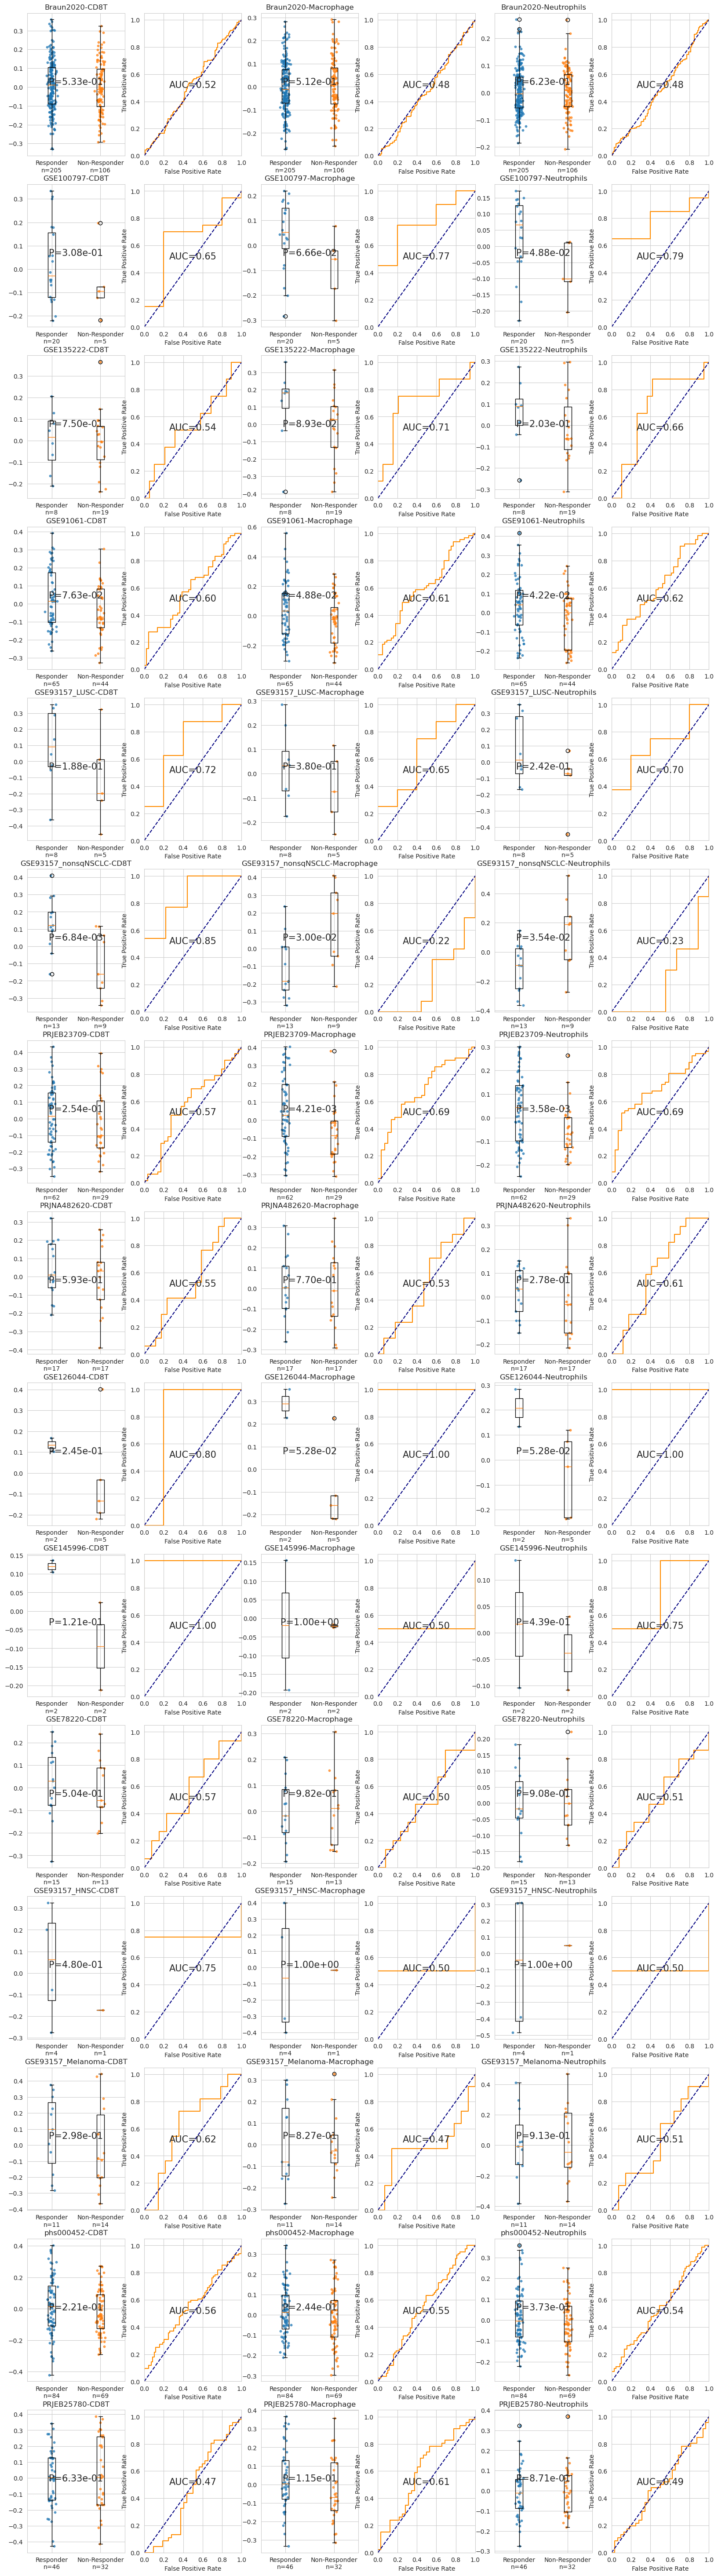

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import ranksums
from sklearn import metrics

celltype_list = ['CD8T', 'Macrophage', 'Neutrophils']
dataset_list = ["Braun2020", "GSE100797", "GSE135222", "GSE91061", "GSE93157_LUSC", "GSE93157_nonsqNSCLC", "PRJEB23709", "PRJNA482620", "GSE126044", "GSE145996", "GSE78220", "GSE93157_HNSC", "GSE93157_Melanoma", "phs000452", "PRJEB25780"]
fig = plt.figure(figsize=(20, 5 * len(dataset_list)))
gs = gridspec.GridSpec(nrows=len(dataset_list), ncols=6, width_ratios=[1, 1, 1, 1, 1, 1])
for celltype in celltype_list:
    for i in range(len(dataset_list)):
        dataset = dataset_list[i]
        # print(f"Process {dataset}")
        correlation_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/5.Analysis_data/{dataset}/{dataset}.correlation.{celltype}.csv'
        correlation_df = pd.read_csv(correlation_path, header=0, index_col=0)
        
        sample_annotation_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/5.Analysis_data/{dataset}/{dataset}.Response.tsv'
        sample_annotation_df = pd.read_csv(sample_annotation_path, delimiter='\t', header=0, index_col=0)
        sample_annotation_df.set_index('sample_id', inplace=True)
            
        # response_correlation = correlation_df.loc[sample_annotation_df[sample_annotation_df['response_NR'] == 'R'].index]
        # nonresponse_correlation = correlation_df.loc[sample_annotation_df[sample_annotation_df['response_NR'] == 'N'].index]
        NR_flag = (sample_annotation_df['response'].isin(['PD', 'N']))
        response_correlation = correlation_df.loc[sample_annotation_df[~NR_flag].index]
        nonresponse_correlation = correlation_df.loc[sample_annotation_df[NR_flag].index]
        if len(response_correlation) == 0 or len(nonresponse_correlation) == 0:
            print(f'{dataset} fail')
            continue
    
        correlation_data = [np.array(response_correlation).ravel(), np.array(nonresponse_correlation).ravel()]
        p_value = ranksums(response_correlation, nonresponse_correlation).pvalue
        p_value_format = format(p_value[0], '0.2e')
        
        if celltype == 'CD8T':
            ax1 = fig.add_subplot(gs[i, 0])
            ax2 = fig.add_subplot(gs[i, 1])
        elif celltype == 'Macrophage':
            ax1 = fig.add_subplot(gs[i, 2])
            ax2 = fig.add_subplot(gs[i, 3])
        elif celltype == 'Neutrophils':
            ax1 = fig.add_subplot(gs[i, 4])
            ax2 = fig.add_subplot(gs[i, 5])
    
        ax1.boxplot(correlation_data)
        # add scatter
        for i in range(len(correlation_data)):
            y = correlation_data[i]
            x = np.random.normal(i + 1, 0.04, size=len(y))
            ax1.scatter(x, y, alpha=0.7, s=10)
        y_mean = (max(max(row) for row in correlation_data) + min(min(row) for row in correlation_data)) / 2
        ax1.text(1.5, y_mean, f'P={p_value_format}', ha='center', fontsize=15)
        ax1.set_xticks([1, 2])
        ax1.set_xticklabels([f'Responder\nn={len(response_correlation)}', f'Non-Responder\nn={len(nonresponse_correlation)}'])
        ax1.set_title(f'{dataset}-{celltype}')
    
        # calculate ROC
        y_true = [1] * len(response_correlation) + [0] * len(nonresponse_correlation)
        y_pred = list(correlation_data[0]) + list(correlation_data[1])
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
        roc_auc = metrics.auc(fpr, tpr)
    
        ax2.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc})')
        ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
        ax2.text(0.5, 0.5, f'AUC={"{:.2f}".format(roc_auc)}', ha='center', fontsize=15)
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
plt.show()